# Sales Data Analysis


This project uses [Knightbearr's sales product data](https://www.kaggle.com/datasets/knightbearr/sales-product-data) which, though contrived, serves as a useful starting point for store sales data analysis.

## Imports

In [1]:
import pandas as pd

## Getting the data

I downloaded the data archive, which comes with twelve files, each containing data for one of the twelve months of the year. To load the data into a Pandas DataFrame, I used the file name convention to my advantage:

In [2]:
months = [
    "January",
    "February",
    "March",
    "April",
    "May",
    "June",
    "July",
    "August",
    "September",
    "October",
    "November",
    "December",
]

df = pd.DataFrame()

for month in months:
    df = pd.concat([df, pd.read_csv("./data/knightbearr-sales-data/Sales_{0}_2019.csv".format(month))], ignore_index = True)

Note that `ignore_index` is set to `True` in the `concat()` call; this is because each DataFrame loaded by the `read_csv()` call in the loop has its own indices and if we don't ignore them, the repetition causes problems with DataFrame concatenation.

As an experiemnt, try to replicate this whole notebook without using the `ignore_index` parameter. You'll see what issues I mean when you get to the grouped monthly sales data.

For now, let's see what sort of data we have:

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186850 entries, 0 to 186849
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Order ID          186305 non-null  object
 1   Product           186305 non-null  object
 2   Quantity Ordered  186305 non-null  object
 3   Price Each        186305 non-null  object
 4   Order Date        186305 non-null  object
 5   Purchase Address  186305 non-null  object
dtypes: object(6)
memory usage: 8.6+ MB


The `object`s in the `Dtype` column indicate that all the columns contain strings, which means we'll have to parse the strings in the `Order ID`, `Quantity Ordered`, `Price Each`, and `Order Date` colummns to get numeric values.

First, though, let's see check the data quality.

## Checking data quality

### Missing values

The simplest data qualit check is seeing if there are missing values. Pandas DataFrames have a convenient `innull()` method that returns a DataFrame with the same dimensions as the DataFrame on which it was called, but filled with booleans indicating whether the value at that row and column is null:

In [4]:
df.isnull().sum()

Order ID            545
Product             545
Quantity Ordered    545
Price Each          545
Order Date          545
Purchase Address    545
dtype: int64

Looks like 545 entries in each column are null-valued. My bet is that there are 545 rows with all null values, rather than 545 entries in each column being randomly null-valued. The latter is too much coincidence: if there _were_ random nulls in each column, what are the odds the number of nulls in every column would be the same?

Just to satisfy curiosity, let's get the rows with null values and see what we can make of them.

In [5]:
df[df.isnull().any(axis=1)]

Order ID Product Quantity Ordered Price Each Order Date  \
664         NaN     NaN              NaN        NaN        NaN   
678         NaN     NaN              NaN        NaN        NaN   
797         NaN     NaN              NaN        NaN        NaN   
876         NaN     NaN              NaN        NaN        NaN   
1299        NaN     NaN              NaN        NaN        NaN   
...         ...     ...              ...        ...        ...   
184678      NaN     NaN              NaN        NaN        NaN   
184695      NaN     NaN              NaN        NaN        NaN   
185042      NaN     NaN              NaN        NaN        NaN   
185729      NaN     NaN              NaN        NaN        NaN   
186463      NaN     NaN              NaN        NaN        NaN   

       Purchase Address  
664                 NaN  
678                 NaN  
797                 NaN  
876                 NaN  
1299                NaN  
...                 ...  
184678              NaN  
184695              NaN  
185042              NaN  
185729              NaN  
186463              NaN  

[545 rows x 6 columns]

As expected, there are 545 rows filled with nulls. What's less expected is that they appear to be randomly distributed, based on a quick glance at the indices. I suppose I expected that they would occur at somewhat regular intervals, e.g. at the end of each of the monthly data files.

Since we know that all the null-valued rows are completely useless, we can drop them:

In [6]:
df.dropna(inplace=True)

In [7]:
df.isnull().sum()

Order ID            0
Product             0
Quantity Ordered    0
Price Each          0
Order Date          0
Purchase Address    0
dtype: int64

Lovely. Now let's perform some other data quality checks.

### Data type consistency

This is a tricky one, because, as we saw earlier, the DataFrame is filled with `string`s. We will have to try to convert each column to the data type it ought to have.

Let's start with the `Order ID` column.

In [8]:
df.sample(10)

Order ID                   Product Quantity Ordered Price Each  \
66636    204804           ThinkPad Laptop                1     999.99   
134239   269429    34in Ultrawide Monitor                1     379.99   
175822   309106          Wired Headphones                1      11.99   
37831    177364           ThinkPad Laptop                1     999.99   
136087   271189  Lightning Charging Cable                1      14.95   
156343   290516     AA Batteries (4-pack)                2       3.84   
55690    194396  Apple Airpods Headphones                1        150   
123064   258760     AA Batteries (4-pack)                1       3.84   
36695    176277              Google Phone                1        600   
114833   250858      USB-C Charging Cable                1      11.95   

            Order Date                           Purchase Address  
66636   05/15/19 09:14  102 Jefferson St, San Francisco, CA 94016  
134239  10/17/19 16:47     578 Walnut St, San Francisco, CA 94016  
175822  12/16/19 22:39       879 Lake St, San Francisco, CA 94016  
37831   04/29/19 15:59       938 Forest St, Los Angeles, CA 90001  
136087  10/21/19 12:34       706 13th St, San Francisco, CA 94016  
156343  11/16/19 18:43     696 Church St, San Francisco, CA 94016  
55690   05/14/19 02:41        788 8th St, San Francisco, CA 94016  
123064  09/10/19 14:34              448 6th St, Atlanta, GA 30301  
36695   03/14/19 19:21    647 Dogwood St, New York City, NY 10001  
114833  09/20/19 15:33              947 Lake St, Austin, TX 73301

Looks like `Order ID` should have one of Python's integer data types. Let's see if any entries don't:

In [9]:
df[df["Order ID"].str.isdecimal() == False].count()

Order ID            355
Product             355
Quantity Ordered    355
Price Each          355
Order Date          355
Purchase Address    355
dtype: int64

Fascinating! Looks like 355 rows contain non-numeric values in every column. Let's check them out.

In [10]:
df[df["Order ID"].str.isdecimal() == False].sample(10)

Order ID  Product  Quantity Ordered  Price Each  Order Date  \
26579   Order ID  Product  Quantity Ordered  Price Each  Order Date   
54309   Order ID  Product  Quantity Ordered  Price Each  Order Date   
75215   Order ID  Product  Quantity Ordered  Price Each  Order Date   
102300  Order ID  Product  Quantity Ordered  Price Each  Order Date   
76880   Order ID  Product  Quantity Ordered  Price Each  Order Date   
1194    Order ID  Product  Quantity Ordered  Price Each  Order Date   
3612    Order ID  Product  Quantity Ordered  Price Each  Order Date   
62752   Order ID  Product  Quantity Ordered  Price Each  Order Date   
66519   Order ID  Product  Quantity Ordered  Price Each  Order Date   
93423   Order ID  Product  Quantity Ordered  Price Each  Order Date   

        Purchase Address  
26579   Purchase Address  
54309   Purchase Address  
75215   Purchase Address  
102300  Purchase Address  
76880   Purchase Address  
1194    Purchase Address  
3612    Purchase Address  
62752   Purchase Address  
66519   Purchase Address  
93423   Purchase Address

I wonder how that might have happened. Then again, this being a contrived dataset, I suppose the important thing is that we are careful to spot these things, rather than why; without knowing how the data was generated, it's almost certain that these rows were programmatically placed in the dataset.

Regardless, let's get rid of them.

In [11]:
df = df[df["Order ID"].str.isdecimal()]
df

Order ID                     Product Quantity Ordered Price Each  \
0        141234                      iPhone                1        700   
1        141235    Lightning Charging Cable                1      14.95   
2        141236            Wired Headphones                2      11.99   
3        141237            27in FHD Monitor                1     149.99   
4        141238            Wired Headphones                1      11.99   
...         ...                         ...              ...        ...   
186845   319666    Lightning Charging Cable                1      14.95   
186846   319667       AA Batteries (4-pack)                2       3.84   
186847   319668             Vareebadd Phone                1        400   
186848   319669            Wired Headphones                1      11.99   
186849   319670  Bose SoundSport Headphones                1      99.99   

            Order Date                        Purchase Address  
0       01/22/19 21:25         944 Walnut St, Boston, MA 02215  
1       01/28/19 14:15        185 Maple St, Portland, OR 97035  
2       01/17/19 13:33   538 Adams St, San Francisco, CA 94016  
3       01/05/19 20:33      738 10th St, Los Angeles, CA 90001  
4       01/25/19 11:59           387 10th St, Austin, TX 73301  
...                ...                                     ...  
186845  12/11/19 20:58  14 Madison St, San Francisco, CA 94016  
186846  12/01/19 12:01    549 Willow St, Los Angeles, CA 90001  
186847  12/09/19 06:43        273 Wilson St, Seattle, WA 98101  
186848  12/03/19 10:39          778 River St, Dallas, TX 75001  
186849  12/21/19 21:45  747 Chestnut St, Los Angeles, CA 90001  

[185950 rows x 6 columns]

Now let's run the check again.

In [12]:
df[df["Order ID"].str.isdecimal() == False].count()

Order ID            0
Product             0
Quantity Ordered    0
Price Each          0
Order Date          0
Purchase Address    0
dtype: int64

And now the same check with other columns:

In [13]:
df[df["Quantity Ordered"].str.isdecimal() == False].count()

Order ID            0
Product             0
Quantity Ordered    0
Price Each          0
Order Date          0
Purchase Address    0
dtype: int64

In [14]:
df[df["Price Each"].str.replace(".", "").str.isnumeric() == False].count()

Order ID            0
Product             0
Quantity Ordered    0
Price Each          0
Order Date          0
Purchase Address    0
dtype: int64

Looks good so far. In order to verify that the `Order Date` column contains only date strings, we'll use the `parse` function from the `dateutil.parser` module.

In [15]:
from dateutil.parser import parse

We'll also write a simple function to handle parsing errors by returning `False`, returning `True` for each successful parse:

In [16]:
def is_date(s):
    try:
        parse(s, fuzzy=True)
        return True
    except:
        return False

Specifying `fuzzy=True` saves us the trouble of going through the data and ensuring all the valid date strings use the same format.

Now we can check the `Order Date` column entries by calling `is_date()`, passing the entry string as the argument `s`:

In [17]:
df[[not is_date(s) for s in df["Order Date"]]].count()

Order ID            0
Product             0
Quantity Ordered    0
Price Each          0
Order Date          0
Purchase Address    0
dtype: int64

Excellent. Looks like all values are accounted for and everything can be converted to its proper type! We'll do that before running some more data quality checks.

## Data type conversion

In [18]:
try:
    df["Order ID"] = df["Order ID"].astype(int)
    df["Quantity Ordered"] = df["Quantity Ordered"].astype(int)
    df["Price Each"] = df["Price Each"].astype(float)
    df["Order Date"] = pd.to_datetime(df["Order Date"], format="%m/%d/%y %H:%M")
except ValueError:
    print("Couldn't convert a value.")

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 185950 entries, 0 to 186849
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Order ID          185950 non-null  int32         
 1   Product           185950 non-null  object        
 2   Quantity Ordered  185950 non-null  int32         
 3   Price Each        185950 non-null  float64       
 4   Order Date        185950 non-null  datetime64[ns]
 5   Purchase Address  185950 non-null  object        
dtypes: datetime64[ns](1), float64(1), int32(2), object(2)
memory usage: 8.5+ MB


In [20]:
df.sample(10)

Order ID                     Product  Quantity Ordered  Price Each  \
89570     226680        USB-C Charging Cable                 1       11.95   
117604    253523        USB-C Charging Cable                 1       11.95   
21876     162118                      iPhone                 1      700.00   
159098    293156                Google Phone                 1      600.00   
78562     216157  Bose SoundSport Headphones                 1       99.99   
77124     214777       AA Batteries (4-pack)                 2        3.84   
175122    308440    Lightning Charging Cable                 1       14.95   
132143    267425            Wired Headphones                 2       11.99   
185200    318085        USB-C Charging Cable                 1       11.95   
171845    305311            27in FHD Monitor                 1      149.99   

                Order Date                         Purchase Address  
89570  2019-07-04 18:03:00           108 Ridge St, Austin, TX 73301  
117604 2019-09-01 17:51:00  690 Hickory St, San Francisco, CA 94016  
21876  2019-03-10 22:32:00     888 13th St, San Francisco, CA 94016  
159098 2019-11-06 09:47:00        319 Meadow St, Portland, OR 97035  
78562  2019-06-09 19:51:00        999 5th St, Los Angeles, CA 90001  
77124  2019-06-28 15:13:00   904 Walnut St, San Francisco, CA 94016  
175122 2019-12-07 21:00:00      367 Maple St, Los Angeles, CA 90001  
132143 2019-10-02 13:29:00     724 Willow St, Los Angeles, CA 90001  
185200 2019-12-07 19:04:00     759 12th St, New York City, NY 10001  
171845 2019-12-10 21:08:00       833 Jefferson St, Dallas, TX 75001

Marvelous.

## Data quality checks, continued

Now that we have data in the right format, let's make sure it's _good_ data, using a combination of data visualization and text output.

Note: this will "void the warranty," so to speak, of our data, in the sense that once we've performed these checks, we will have performed so many tests on the data that we can no longer run traditional hypothesis tests due to the [multiple comparisons problem](https://en.wikipedia.org/wiki/Multiple_comparisons_problem). The multiple comparisons problem will arise because every time we compare two variables or see the sample distribution of a variable, we will essentially have performed a hypothesis test on it. As more and more hypothesis tests are run on a set of data, the more likely it is that a spurious correlation, or a correlation that has arisen purely due to coincidence and doesn't exist in reality, will be encountered. There are ways (corrections) to account for that (see the "Controlling procedures" section of the linked Wikipedia page), but a) it's not the same as having "fresh" data, and b) we are not particularly interested in testing any hypotheses at the moment. In fact, analyzing this data is largely what will _lead_ to hypotheses we want to test! We just won't be able to test them, unless we can get another set of data from the same store, collected the same way as this data.

First, let's use the `pandas.DataFrame.describe()` method to get a quick overview of the data.

### General information

In [21]:
df.describe()

Order ID  Quantity Ordered     Price Each  \
count  185950.000000     185950.000000  185950.000000   
mean   230417.569379          1.124383     184.399735   
min    141234.000000          1.000000       2.990000   
25%    185831.250000          1.000000      11.950000   
50%    230367.500000          1.000000      14.950000   
75%    275035.750000          1.000000     150.000000   
max    319670.000000          9.000000    1700.000000   
std     51512.737110          0.442793     332.731330   

                          Order Date  
count                         185950  
mean   2019-07-18 21:54:38.887550208  
min              2019-01-01 03:07:00  
25%              2019-04-16 21:05:15  
50%              2019-07-17 20:40:30  
75%              2019-10-26 08:14:00  
max              2020-01-01 05:13:00  
std                              NaN

Here are a few observations we can make based on just this:
1. The maximum `Quantity Ordered` is 9, yet the 75th percentile is 1; this means that more than one of an items is ordered less than 25% of the time. This is further supported by the standard deviation of `Quantity Ordered` being only ~0.44.
2. The most expensive item in the store costs \\$1,700.
3. There is an order on the first of January, 2020 &mdash; we should get rid of that data point (as well as any others that do not take place in 2019) to confine ourselves purely to 2019 data.
4. Order dates are pretty evenly distributed: the minimum is January 1, the first quartile is mid April, the median is late-mid July, the third quartile is late October, and the maximum, is the first day of the new year.

Now let's perform some simple visual analyses on each numeric column's distribution, and see what we can learn.

### Data distributions

array([[<Axes: title={'center': 'Quantity Ordered'}>,
        <Axes: title={'center': 'Price Each'}>],
       [<Axes: title={'center': 'Order Date'}>, <Axes: >]], dtype=object)

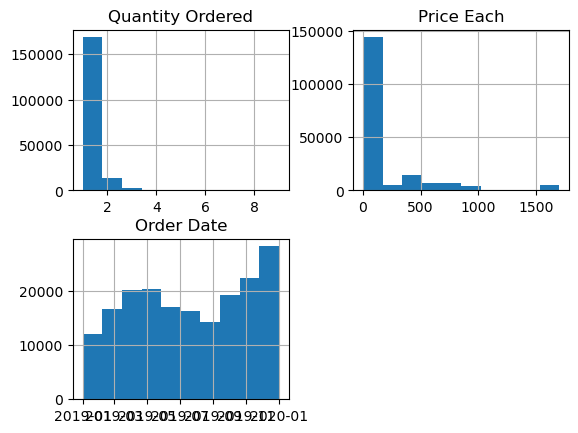

In [22]:
df[["Quantity Ordered", "Price Each", "Order Date"]].hist()

Rough, but informative.

The distribution of the values in the `Quantity Ordered` column confirms our earlier inference that most orders contain a single item. The histogram additionally tells us that hardly any orders contain more than three of any item.

The `Order Date` distribution tells us how busy the store was during various times of the year. That end-of-year peak could mean that the store's sales are on the rise year-over-year, but I suspect it's more likely to be explained by the fact that December incentives shopping, due to Christmas, Boxing Day, and the New Year. We would need to see data for January and a bit later of 2020 to be certain.

The `Price Each` histogram is particularly interesting. Inexpensive items comprise the vast majority of orders, which makes sense, but there is an out-of-place bump in sales of items costing more than \\$1,500. Why? Let's see what items have a price greater than \\$1,500 and see if we can infer the reason.

In [23]:
df[df["Price Each"] > 1500].sample(10)

Order ID             Product  Quantity Ordered  Price Each  \
75415     213164  Macbook Pro Laptop                 1      1700.0   
166289    299996  Macbook Pro Laptop                 1      1700.0   
139333    274282  Macbook Pro Laptop                 1      1700.0   
165746    299483  Macbook Pro Laptop                 1      1700.0   
102088    238681  Macbook Pro Laptop                 1      1700.0   
134493    269669  Macbook Pro Laptop                 1      1700.0   
62429     200798  Macbook Pro Laptop                 1      1700.0   
14207     154774  Macbook Pro Laptop                 1      1700.0   
171612    305081  Macbook Pro Laptop                 1      1700.0   
109102    245375  Macbook Pro Laptop                 1      1700.0   

                Order Date                           Purchase Address  
75415  2019-06-15 18:11:00       928 Forest St, Los Angeles, CA 90001  
166289 2019-12-10 12:37:00        786 9th St, New York City, NY 10001  
139333 2019-10-03 14:47:00       29 South St, San Francisco, CA 94016  
165746 2019-12-15 14:27:00       235 Sunset St, Los Angeles, CA 90001  
102088 2019-08-22 13:59:00  75 Washington St, New York City, NY 10001  
134493 2019-10-20 16:21:00    961 Jackson St, New York City, NY 10001  
62429  2019-05-17 08:25:00        25 13th St, San Francisco, CA 94016  
14207  2019-02-24 07:44:00     583 Chestnut St, Los Angeles, CA 90001  
171612 2019-12-03 17:36:00    66 Highland St, New York City, NY 10001  
109102 2019-08-29 19:48:00             254 5th St, Portland, OR 97035

That makes sense, the Macbook Pro is an extremely popular personal computer.

Occasionally, datasets will collect all values beyond a cutoff point into the same maximum value. For instance, a real estate dataset may have a price cutoff of \\$1,000,000, and any properies with values exceeding that will be counted as having a price of \\$1,000,000, resulting in a bump on the right edge of the price histogram. I'm glad to see that's not what happened here.

Everything checks out in terms of data quality, so let's move on to data transformation!

## Data transformation

Remember that we got rid of several rows earlier, because they contained null values or contained the column names rather than any useful information; that messed up our index, because now there are "holes" in it. It's possibly not a big deal, but I prefer to have all the useful data logically sorted and indexed. So let's sort and reindex our DataFrame.

In [24]:
df.sort_values(by = "Order ID", inplace = True)
df.reset_index(drop = True, inplace = True)

Next, remember that we discovered earlier that the maximum `Order Date` is January 1, 2020. Since this is an analysis of 2019 data, we don't want any 2020 orders, so let's get rid of those rows. But first, I'm curious to see how many 2020 orders made it into this data set.

In [25]:
df[df["Order Date"] >= parse("01/01/2020")]

Order ID                     Product  Quantity Ordered  Price Each  \
162516    297150    Lightning Charging Cable                 1       14.95   
163216    297817                      iPhone                 1      700.00   
163217    297817    Lightning Charging Cable                 2       14.95   
163376    297969                Google Phone                 1      600.00   
163757    298344            Wired Headphones                 4       11.99   
164498    299049    Apple Airpods Headphones                 1      150.00   
164578    299125        USB-C Charging Cable                 1       11.95   
165875    300362        USB-C Charging Cable                 1       11.95   
166037    300519  Bose SoundSport Headphones                 1       99.99   
166038    300519    Lightning Charging Cable                 1       14.95   
166287    300759                20in Monitor                 1      109.99   
167973    302393    Lightning Charging Cable                 1       14.95   
169828    304165      AAA Batteries (4-pack)                 1        2.99   
171262    305538    Apple Airpods Headphones                 1      150.00   
171575    305840  Bose SoundSport Headphones                 1       99.99   
172424    306655             ThinkPad Laptop                 1      999.99   
172586    306809          Macbook Pro Laptop                 1     1700.00   
172712    306928             ThinkPad Laptop                 1      999.99   
173700    307890    Lightning Charging Cable                 1       14.95   
174007    308185            27in FHD Monitor                 1      149.99   
174148    308322  Bose SoundSport Headphones                 1       99.99   
175970    310074    Apple Airpods Headphones                 1      150.00   
177325    311386                      iPhone                 1      700.00   
177326    311386    Apple Airpods Headphones                 1      150.00   
177979    312012            27in FHD Monitor                 1      149.99   
178816    312812               Flatscreen TV                 1      300.00   
180127    314066        USB-C Charging Cable                 1       11.95   
180627    314552      AAA Batteries (4-pack)                 1        2.99   
181237    315138      AAA Batteries (4-pack)                 3        2.99   
181420    315315      27in 4K Gaming Monitor                 1      389.99   
183007    316833             Vareebadd Phone                 1      400.00   
183042    316867            27in FHD Monitor                 1      149.99   
185575    319308        USB-C Charging Cable                 1       11.95   
185637    319366                20in Monitor                 2      109.99   

                Order Date                          Purchase Address  
162516 2020-01-01 00:38:00           427 Wilson St, Dallas, TX 75001  
163216 2020-01-01 00:22:00      519 13th St, New York City, NY 10001  
163217 2020-01-01 00:22:00      519 13th St, New York City, NY 10001  
163376 2020-01-01 00:54:00       542 2nd St, San Francisco, CA 94016  
163757 2020-01-01 03:34:00       731 7th St, New York City, NY 10001  
164498 2020-01-01 01:17:00   762 Johnson St, San Francisco, CA 94016  
164578 2020-01-01 04:21:00   754 Hickory St, New York City, NY 10001  
165875 2020-01-01 00:59:00     581 River St, San Francisco, CA 94016  
166037 2020-01-01 05:13:00    657 Spruce St, New York City, NY 10001  
166038 2020-01-01 05:13:00    657 Spruce St, New York City, NY 10001  
166287 2020-01-01 00:14:00              193 5th St, Austin, TX 73301  
167973 2020-01-01 00:14:00        108 Jefferson St, Boston, MA 02215  
169828 2020-01-01 04:13:00          825 Adams St, Portland, OR 97035  
171262 2020-01-01 01:00:00            693 1st St, Portland, OR 97035  
171575 2020-01-01 04:54:00     784 River St, San Francisco, CA 94016  
172424 2020-01-01 01:46:00     431 Hickory St, Los Angeles, CA 90001  
172586 2020-01-01 02:20:00             326 14th St, Dallas, TX 75001  

Not many when compared to the size of the dataset, but a lot more than I expected. Instead of just discarding it, let's put this stuff into a new DataFrame, separate from our 2019 data. We'll also put the 2019 data into its own DataFrame. This ensures we have the original data, should we ever want to refer to it.

In [26]:
data_2020 = df.loc[df["Order Date"] >= parse("01/01/2020")].copy()
data_2019 = df.loc[df["Order Date"] < parse("01/01/2020")].copy()

In [27]:
data_2019.describe()

Order ID  Quantity Ordered     Price Each  \
count  185916.000000     185916.000000  185916.000000   
mean   230403.546526          1.124368     184.387720   
min    141234.000000          1.000000       2.990000   
25%    185822.750000          1.000000      11.950000   
50%    230351.500000          1.000000      14.950000   
75%    275015.250000          1.000000     150.000000   
max    319670.000000          9.000000    1700.000000   
std     51506.924899          0.442749     332.722426   

                          Order Date  
count                         185916  
mean   2019-07-18 21:10:53.291163392  
min              2019-01-01 03:07:00  
25%              2019-04-16 20:52:00  
50%              2019-07-17 20:09:30  
75%              2019-10-26 06:58:00  
max              2019-12-31 23:53:00  
std                              NaN

In [28]:
data_2020.describe()

Order ID  Quantity Ordered   Price Each  \
count      34.000000         34.000000    34.000000   
mean   307096.176471          1.205882   250.100000   
min    297150.000000          1.000000     2.990000   
25%    300519.000000          1.000000    14.950000   
50%    306868.500000          1.000000   109.990000   
75%    312612.000000          1.000000   262.500000   
max    319366.000000          4.000000  1700.000000   
std      6959.955266          0.640994   378.149071   

                          Order Date  
count                             34  
mean   2020-01-01 01:59:08.823529472  
min              2020-01-01 00:10:00  
25%              2020-01-01 00:46:30  
50%              2020-01-01 01:46:00  
75%              2020-01-01 03:09:15  
max              2020-01-01 05:13:00  
std                              NaN

Excellent. Now we can move on to analysis.

## Data analysis

A good rule of thumb in data analysis, especially in _exploratory_ data analysis, when we don't have a specific question we're interested in, is to get a big picture overview of general information and then get progressively more specific as questions arise.

Since we're analyzing store data, let's start by checking out the year's sales statistics.

### Total sales in 2019

Since the data records each type item sold at a time as its own order, the year's total sales will be equal to each order's `Quantity Ordered` multiplied by the item's `Price Each`.

In [29]:
total_sales = (data_2019["Quantity Ordered"] * data_2019["Price Each"]).sum()
total_sales

34483365.67999999

So, in 2019, the store had a revenue of around \\$3,448,365.68. Not bad, though without knowing where the store is geographically, how many employees it has, and what its costs are, there's no way to tell whether that's objectively good. In a very high cost of living area, with many employees, and high costs, each employee and store owner may not have lavish lifestyles. On the other hand, if it's in a low cost of living area, with only a few employees, and not much cash outflow, the store's employees could be living like royalty.

Let's get a bit more specific, and examine the monthly statistics.

### Monthly statistics


The `Order Date` histogram we created previously in the data quality check section gave us an overview of how orders are distributed by month, but we don't know if sales (i.e. revenue) follow the same distribution. Let's find out!

If we're going to be splitting data up based on unique values of a categorical variable, though, it's convenient to have a column containing specifically the values of that variable. Currently, the month of each order is tied up in its `Order Date`, and we'd have to parse each entry individually to extract the order's month. That's both computationally expensive and a messy thing to code. So let's create new colummns for the number and name of the month of each order (e.g. April is number 4), as well as separate columns for the day of the month, day of the year (e.g. February 1 is the 32nd day of the year), and weekday (Sunday, Monday, etc.). This will let us investigate such things as whether sales spike on December 24th, see sales as a per-day time series spanning the duration of 2019, and how the day of the week impacts sales.

We will need to import the `datetime.datetime` module first.

#### Further data transformation

In [30]:
from datetime import datetime

In [31]:
data_2019.loc[:, "Month Number"] = pd.Series(data_2019.loc[:, "Order Date"].map(lambda d: d.month)).astype("Int8")
data_2019.loc[:, "Month Name"] = pd.Series(data_2019.loc[:, "Order Date"].map(lambda d: d.month_name()))
data_2019.loc[:, "Day of Month"] = pd.Series(data_2019.loc[:, "Order Date"].map(lambda d: d.day)).astype("Int8")

date_offset = data_2019.loc[:, "Order Date"].min().toordinal() + 1

data_2019.loc[:, "Ordinal Day"] = pd.Series(data_2019.loc[:, "Order Date"].map(lambda d: d.toordinal() - date_offset)).astype("Int16")
data_2019.loc[:, "Weekday"] = pd.Series(data_2019.loc[:, "Order Date"].map(lambda d: d.day_name()))

In [32]:
data_2019.sample(10)

Order ID                   Product  Quantity Ordered  Price Each  \
108912    245700  Lightning Charging Cable                 1       14.95   
67941     206353      USB-C Charging Cable                 1       11.95   
88851     226404             Flatscreen TV                 1      300.00   
166490    300956    AAA Batteries (4-pack)                 1        2.99   
90461     227949      USB-C Charging Cable                 1       11.95   
155057    290000     AA Batteries (4-pack)                 1        3.84   
45959     185322                  LG Dryer                 1      600.00   
54159     193192          Wired Headphones                 1       11.99   
776       141982          27in FHD Monitor                 1      149.99   
123560    259803        Macbook Pro Laptop                 1     1700.00   

                Order Date                        Purchase Address  \
108912 2019-08-29 11:14:00          803 Cedar St, Boston, MA 02215   
67941  2019-05-03 08:53:00  509 Spruce St, San Francisco, CA 94016   
88851  2019-07-11 22:44:00   383 River St, New York City, NY 10001   
166490 2019-12-18 14:32:00    126 Washington St, Atlanta, GA 30301   
90461  2019-07-05 00:43:00          815 Cedar St, Dallas, TX 75001   
155057 2019-11-08 11:37:00            953 2nd St, Dallas, TX 75001   
45959  2019-04-18 12:49:00            269 5th St, Boston, MA 02215   
54159  2019-04-27 12:34:00      858 Hickory St, Portland, OR 97035   
776    2019-01-11 15:57:00      624 Highland St, Atlanta, GA 30301   
123560 2019-10-18 00:35:00      861 Main St, Los Angeles, CA 90001   

        Month Number Month Name  Day of Month  Ordinal Day    Weekday  
108912             8     August            29          239   Thursday  
67941              5        May             3          121     Friday  
88851              7       July            11          190   Thursday  
166490            12   December            18          350  Wednesday  
90461              7       July             5          184     Friday  
155057            11   November             8          310     Friday  
45959              4      April            18          106   Thursday  
54159              4      April            27          115   Saturday  
776                1    January            11            9     Friday  
123560            10    October            18          289     Friday

In [33]:
data_2019.info()

<class 'pandas.core.frame.DataFrame'>
Index: 185916 entries, 0 to 185949
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Order ID          185916 non-null  int32         
 1   Product           185916 non-null  object        
 2   Quantity Ordered  185916 non-null  int32         
 3   Price Each        185916 non-null  float64       
 4   Order Date        185916 non-null  datetime64[ns]
 5   Purchase Address  185916 non-null  object        
 6   Month Number      185916 non-null  Int8          
 7   Month Name        185916 non-null  object        
 8   Day of Month      185916 non-null  Int8          
 9   Ordinal Day       185916 non-null  Int16         
 10  Weekday           185916 non-null  object        
dtypes: Int16(1), Int8(2), datetime64[ns](1), float64(1), int32(2), object(4)
memory usage: 12.6+ MB


In [34]:
data_2019.describe()

Order ID  Quantity Ordered     Price Each  \
count  185916.000000     185916.000000  185916.000000   
mean   230403.546526          1.124368     184.387720   
min    141234.000000          1.000000       2.990000   
25%    185822.750000          1.000000      11.950000   
50%    230351.500000          1.000000      14.950000   
75%    275015.250000          1.000000     150.000000   
max    319670.000000          9.000000    1700.000000   
std     51506.924899          0.442749     332.722426   

                          Order Date  Month Number  Day of Month  Ordinal Day  
count                         185916      185916.0      185916.0     185916.0  
mean   2019-07-18 21:10:53.291163392      7.060248     15.762231   197.261435  
min              2019-01-01 03:07:00           1.0           1.0         -1.0  
25%              2019-04-16 20:52:00           4.0           8.0        104.0  
50%              2019-07-17 20:09:30           7.0          16.0        196.0  
75%              2019-10-26 06:58:00          10.0          23.0        297.0  
max              2019-12-31 23:53:00          12.0          31.0        363.0  
std                              NaN      3.502358      8.780711   107.145549

Perfect. Now, let's analyze.

#### Total monthly sales

<Axes: xlabel='Month Number'>

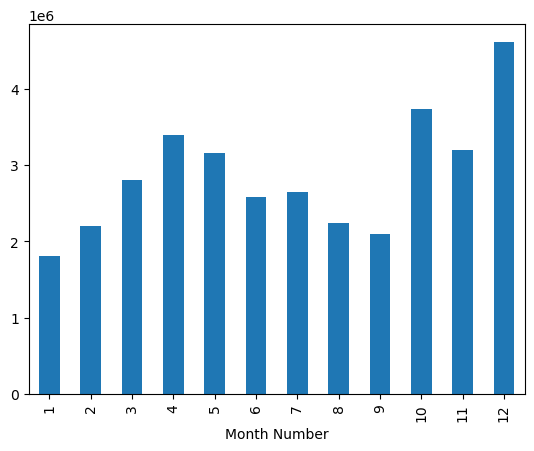

In [35]:
total_monthly_sales = (data_2019["Quantity Ordered"] * data_2019["Price Each"]).groupby(data_2019["Month Number"]).sum()
total_monthly_sales.plot(kind="bar")

For comparison, here's the twelve-bin histogram of `Order Date`s:

<Axes: >

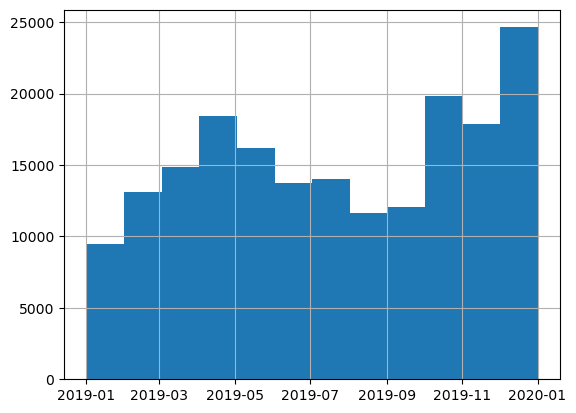

In [36]:
data_2019["Order Date"].hist(bins=12)

The distribution of total monthly sales follows the approximate distribution of orders per month. No surprises there. This means that there aren't any major shifts in the percentage of orders per month that each item makes up.

For example, suppose that in April, almost all orders were of expensive electronics like the Macbook Pro or the iPhone; in that case, the bar representing monthly sales in April would be significantly taller than it is, and the distribution would have a pretty glaring difference when compared to the orders-per-month distribution.

#### Average monthly sales

<Axes: xlabel='Month Number'>

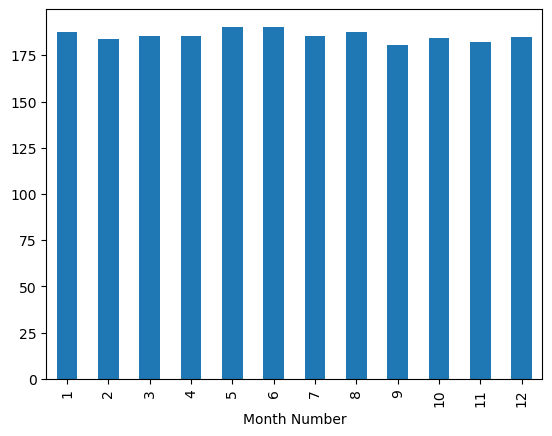

In [37]:
average_monthly_sales = (data_2019["Quantity Ordered"] * data_2019["Price Each"]).groupby(data_2019["Month Number"]).mean()
average_monthly_sales.plot(kind="bar")

Hardly any variation in the average sales per month. Interesting. I would've thought that there would be a significant spike in August and September, thinking that a somewhat larger portion of sales would comprise new phones and laptops due to academic institutions starting a new year, and in December, due to the same change in portion but caused by Christmas and the new year.

Maybe the monthly orders are different?

#### Total monthly orders

<Axes: xlabel='Month Number'>

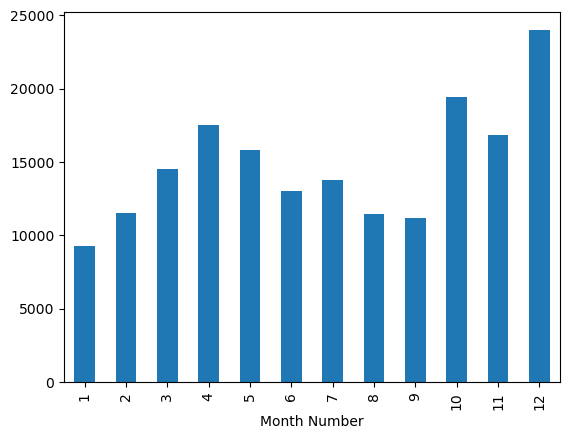

In [38]:
total_monthly_orders = data_2019.groupby(data_2019["Month Number"])["Order ID"].nunique()
total_monthly_orders.plot(kind="bar")

Nothing unexpected here either. Of course, if the distribution of the number of orders per month resembles the distribution of total sales per month, it's practically guaranteed that the distribution of the average price per order per month is going to be more or less a horizontal line, i.e. constant. Let's verify that, though.

#### Average spent per order per month

<Axes: xlabel='Month Number'>

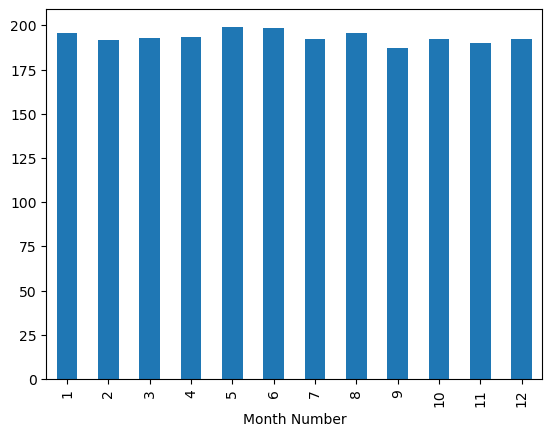

In [39]:
avg_monthly_order_price = total_monthly_sales / total_monthly_orders
avg_monthly_order_price.plot(kind="bar")

Approximately constant, as expected. In fact, let's be _really_ sure. Let's add a regression line to this bar plot.

We will need `numpy` and `matplotlib`.

In [40]:
import numpy as np
import matplotlib.pyplot as plt

By the way, in addition to the official documentation, I also recommend [this](https://realpython.com/python-matplotlib-guide/) excellent guide on the Real Python website, written by Brad Solomon, for a high-level understanding of Matplotlib.

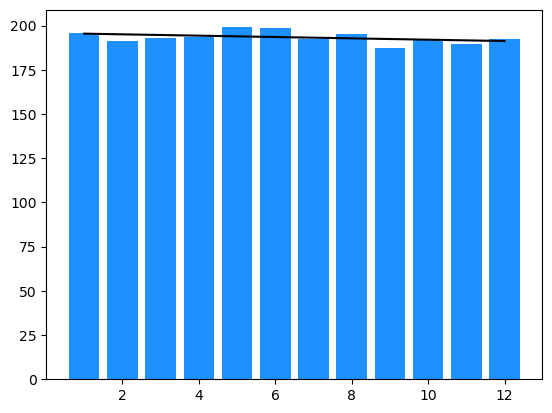

In [41]:
x = avg_monthly_order_price.index.to_list()
y = avg_monthly_order_price.values

fig, ax = plt.subplots()

ax.bar(x, y, color="dodgerblue")

params = np.polyfit(x, y, 1)
curve = np.poly1d(params)

ax.plot(x, curve(x), "black")

plt.show()

I also took the liberty of changing the bars' colour to a more attractive blue.

Anyway, you can see that the regression line is almost perfectly horizontal, indicating almost no change in the monthly average spending per order.
We can see the exact parameters of the line, too:

In [42]:
params

array([ -0.37872812, 195.84685675])

The line has a slope of around -0.4 and a y-intercept of around 196.

I think that's the most we can really do with the monthly timeframe. The thing with months is that they're just long enough that the weather can change noticeably in between them, and only a few months exist between major social and economic events like the resuming of academics in September, Halloween in October, Christmas in December, Valentine's Day in February, spring break, summer vacation, etc. All of these things can affect purchases pretty significantly, so without being able to compare data for the same season over multiple years, monthly data turns out not to be terribly useful.

### Daily statistics

Daily statistics are found in largely the same way as monthly statistics; I'm currently not too interested in those.

I am, however, interested in...

### Demographics

Where do most sales come from? Are people from certain areas more likely to purchase certain things? This is the interesting stuff!

Let's start by analyzing the distribution of total sales by state. To do that, we'll create new columns for each order's customer's state, and also their city and zip code, just in case.

#### Further data transformation

In [43]:
data_2019.loc[:, "State"] = pd.Series(data_2019.loc[:, "Purchase Address"].map(lambda s: s.split(",")[2].strip()[0:2]))
data_2019.loc[:, "City"] = pd.Series(data_2019.loc[:, "Purchase Address"].map(lambda s: s.split(",")[1].strip()))
data_2019.loc[:, "Zip Code"] = pd.Series(data_2019.loc[:, "Purchase Address"].map(lambda s: s.split(",")[2].strip()[3:]))

data_2019

Order ID                     Product  Quantity Ordered  Price Each  \
0         141234                      iPhone                 1      700.00   
1         141235    Lightning Charging Cable                 1       14.95   
2         141236            Wired Headphones                 2       11.99   
3         141237            27in FHD Monitor                 1      149.99   
4         141238            Wired Headphones                 1       11.99   
...          ...                         ...               ...         ...   
185945    319666    Lightning Charging Cable                 1       14.95   
185946    319667       AA Batteries (4-pack)                 2        3.84   
185947    319668             Vareebadd Phone                 1      400.00   
185948    319669            Wired Headphones                 1       11.99   
185949    319670  Bose SoundSport Headphones                 1       99.99   

                Order Date                        Purchase Address  \
0      2019-01-22 21:25:00         944 Walnut St, Boston, MA 02215   
1      2019-01-28 14:15:00        185 Maple St, Portland, OR 97035   
2      2019-01-17 13:33:00   538 Adams St, San Francisco, CA 94016   
3      2019-01-05 20:33:00      738 10th St, Los Angeles, CA 90001   
4      2019-01-25 11:59:00           387 10th St, Austin, TX 73301   
...                    ...                                     ...   
185945 2019-12-11 20:58:00  14 Madison St, San Francisco, CA 94016   
185946 2019-12-01 12:01:00    549 Willow St, Los Angeles, CA 90001   
185947 2019-12-09 06:43:00        273 Wilson St, Seattle, WA 98101   
185948 2019-12-03 10:39:00          778 River St, Dallas, TX 75001   
185949 2019-12-21 21:45:00  747 Chestnut St, Los Angeles, CA 90001   

        Month Number Month Name  Day of Month  Ordinal Day    Weekday State  \
0                  1    January            22           20    Tuesday    MA   
1                  1    January            28           26     Monday    OR   
2                  1    January            17           15   Thursday    CA   
3                  1    January             5            3   Saturday    CA   
4                  1    January            25           23     Friday    TX   
...              ...        ...           ...          ...        ...   ...   
185945            12   December            11          343  Wednesday    CA   
185946            12   December             1          333     Sunday    CA   
185947            12   December             9          341     Monday    WA   
185948            12   December             3          335    Tuesday    TX   
185949            12   December            21          353   Saturday    CA   

                 City Zip Code  
0              Boston    02215  
1            Portland    97035  
2       San Francisco    94016  
3         Los Angeles    90001  
4              Austin    73301  
...               ...      ...  
185945  San Francisco    94016  
185946    Los Angeles    90001  
185947        Seattle    98101  
185948         Dallas    75001  
185949    Los Angeles    90001  

[185916 rows x 14 columns]

Lovely. Now we can analyze.

#### What states do orders come from?

<Axes: xlabel='State'>

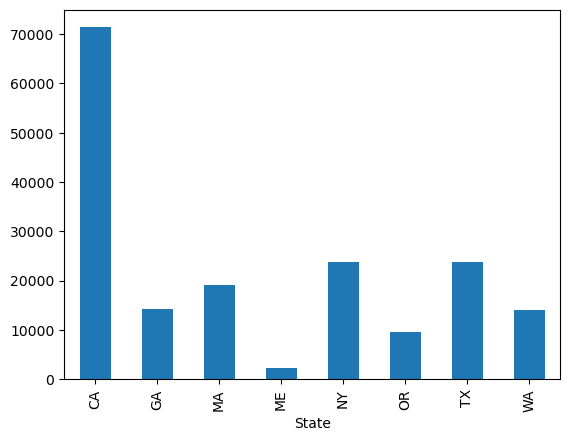

In [44]:
state_orders = data_2019.groupby("State")["Order ID"].nunique()
state_orders.plot(kind="bar")

In [45]:
state_orders.sort_values(ascending = False)

State
CA    71384
NY    23840
TX    23745
MA    19088
GA    14253
WA    14118
OR     9615
ME     2363
Name: Order ID, dtype: int64

Looks like the states from which orders are made are, in descending order of number of orders, California, New York, Texas, Massachusetts, Georgia, Washington, Oregon, and Maine, with California ordering more than New York, Texas, and Massachusetts put together.

But do more orders necessarily translate into more revenue from each state? Let's see.

#### Sales by state

<Axes: xlabel='State'>

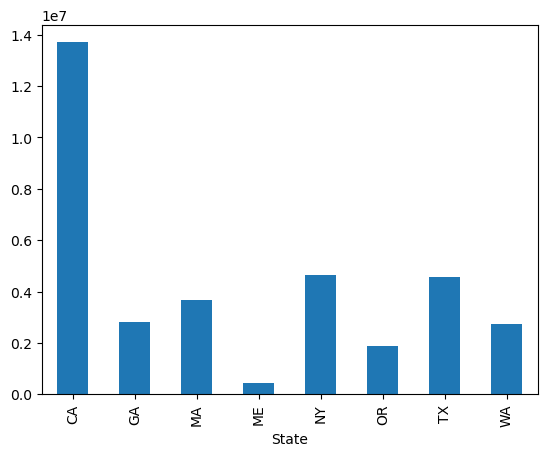

In [46]:
state_sales = (data_2019["Quantity Ordered"] * data_2019["Price Each"]).groupby(data_2019["State"]).sum()
state_sales.plot(kind="bar")

In [47]:
state_sales.sort_values(ascending = False)

State
CA    13711289.84
NY     4662976.81
TX     4585342.22
MA     3660315.12
GA     2795498.58
WA     2747605.49
OR     1870579.35
ME      449758.27
dtype: float64

Looks like there is indeed a _very_ strong correlation between the number of orders and revenue from each state. Which makes sense, though, truth be told, I was hoping for something unexpected.

Maybe there's something to see in the per-city data?

#### Orders and revenue by city

This time, let's skip the prose and get fancy with the code.

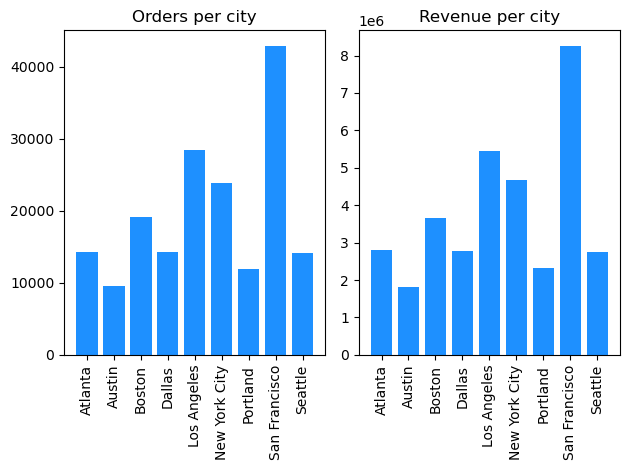

In [48]:
city_orders = data_2019.groupby("City")["Order ID"].nunique()
city_sales = (data_2019["Quantity Ordered"] * data_2019["Price Each"]).groupby(data_2019["City"]).sum().reindex(city_orders.index)

x = city_orders.index.to_list()
y1 = city_orders
y2 = city_sales

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.bar(x, y1, color="dodgerblue")
ax2.bar(x, y2, color="dodgerblue")

ax1.set_title("Orders per city")
ax2.set_title("Revenue per city")

ax1.tick_params(axis="x", labelrotation=90)
ax2.tick_params(axis="x", labelrotation=90)

fig.tight_layout()

plt.show()

Identical. The final topic to analyze is the products themselves.

### Product analysis

This section will be a sort of aggregate of exploration. We'll get the prices of all the products, examine how many orders each product has, and see how much each product contributed to yearly revenue in 2019.

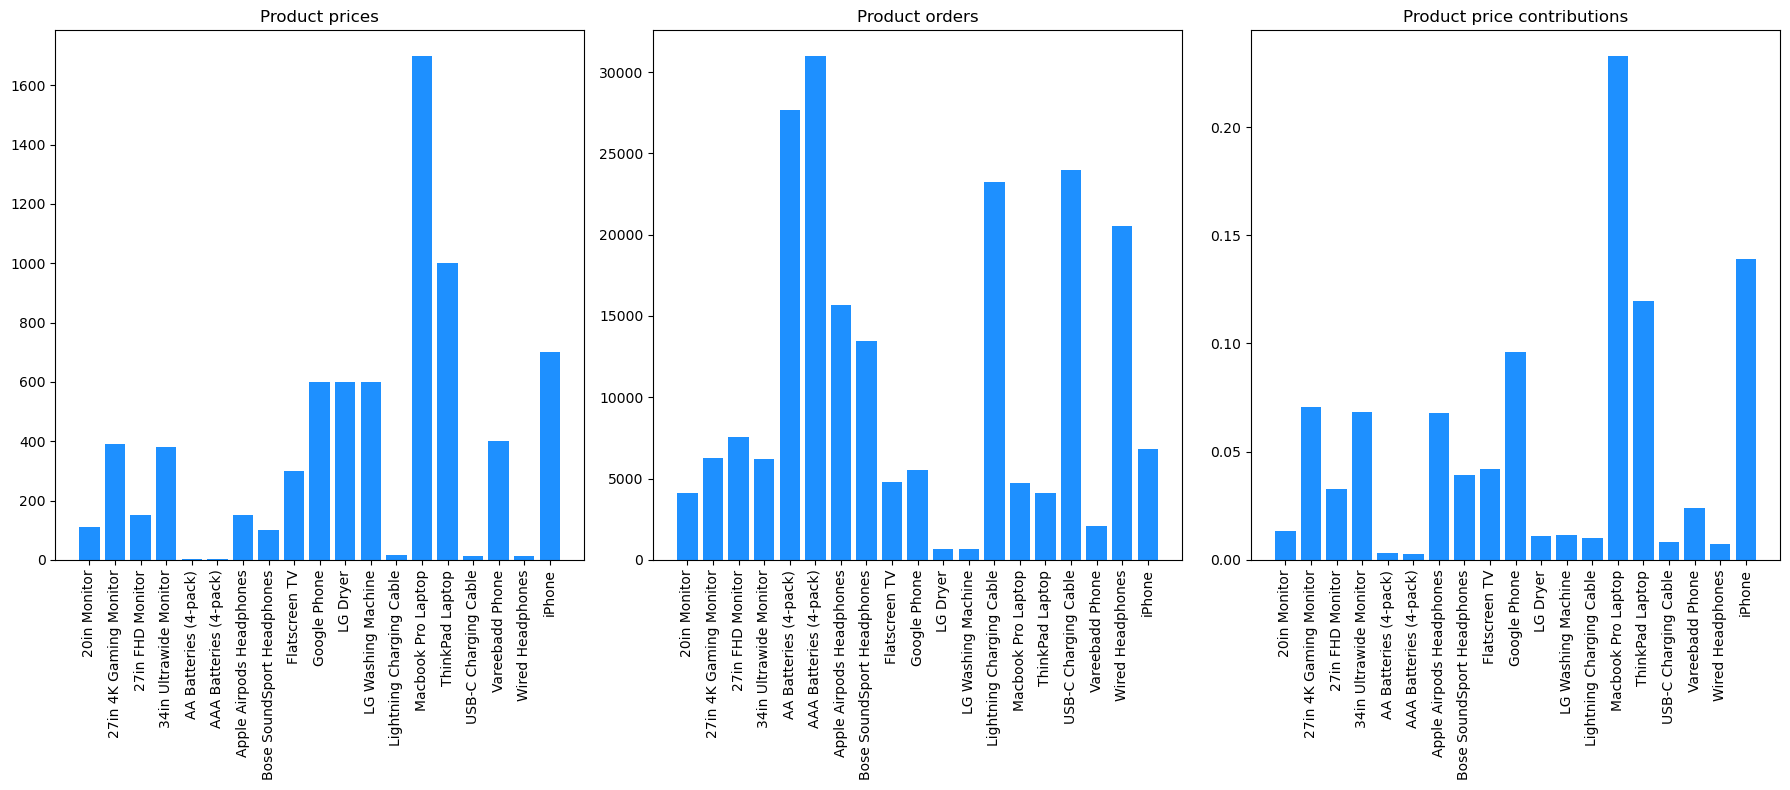

In [49]:
product_prices = data_2019["Price Each"].groupby(data_2019["Product"]).mean()
product_orders = data_2019["Quantity Ordered"].groupby(data_2019["Product"]).sum().reindex(product_prices.index)
product_sales_contributions = (data_2019["Quantity Ordered"] * data_2019["Price Each"]).groupby(data_2019["Product"]).sum().reindex(product_prices.index) / total_sales  # We found total_sales near the beginning of this notebook

y1 = product_prices
y2 = product_orders
y3 = product_sales_contributions
x = product_prices.index.to_list()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 8))

ax1.bar(x, y1, color="dodgerblue")
ax2.bar(x, y2, color="dodgerblue")
ax3.bar(x, y3, color="dodgerblue")

ax1.set_title("Product prices")
ax2.set_title("Product orders")
ax3.set_title("Product price contributions")

ax1.tick_params(axis="x", labelrotation=90)
ax2.tick_params(axis="x", labelrotation=90)
ax3.tick_params(axis="x", labelrotation=90)

fig.tight_layout()

plt.show()

Unsurprisingly, the least expensive items sell the most, and vice versa.

What is most interesting is the product sales contribution chart in the context of the other two. Here are some observations:
1. The batteries, charging cables, and wired headphones, which are very inexpensive and sold the most, contributed hardly anything to the yearly revenue.
2. On the other hand, the Macbook Pro, iPhone, and ThinkPad laptop, which are the three most expensive and least ordered products, contributed the most to yearly revenue.
3. The appliances are mid-range in terms of price but sold so few units that their combined contribution to yearly revenue was less than 3%.
4. The 20in monitor is cheap, sold a meager number of units, and had a yearly revenue contribution of less than 2%.
5. The Vareebadd phone (yes, yes &mdash; remember this isn't real world data, most store owners are hesitant to have their yearly numbers be known so we make do with what we have) isn't terribly expensive, but sold very few unuits and had a yearly revenue contribution of around 2.5%.

Based on this, we can make a few recommendations:
1. Get rid of the appliances and focus exclusively on small electronics and their accessories.
2. Get rid of the 20in monitor and Vareebadd phone and focus exclusively on brand name, high quality products.
3. Things like batteries, charging cables, and wired headphones, though contributing very little to yearly revenue, are probably cheap enough to order in bulk and keep in stock, so maybe those things can be shown in a "Recommended" items section when the customer goes to checkout their order?

Next, I want to plot the proportion of orders each product constitutes per month, as well as per state.

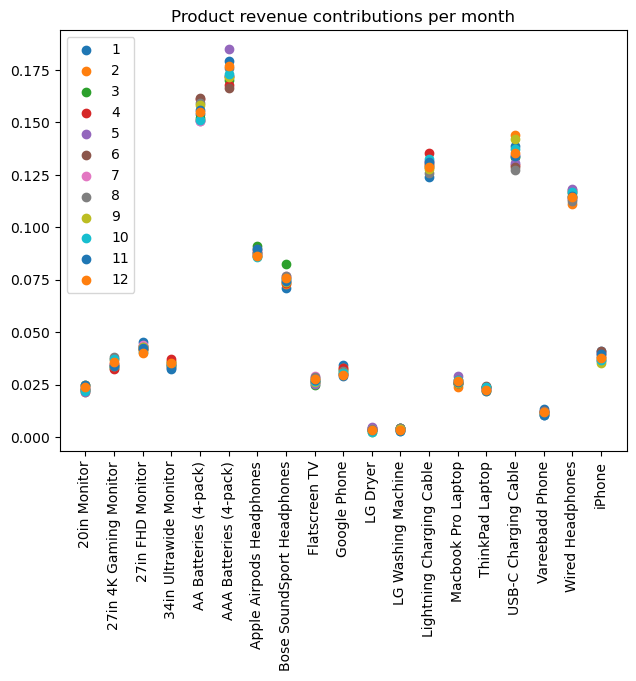

In [50]:
product_order_proportions_per_month = data_2019.groupby(["Month Number", "Product"])["Quantity Ordered"].sum()

month_numbers = product_order_proportions_per_month.index.levels[0].to_list()
x = product_order_proportions_per_month.index.levels[1]

fig, ax = plt.subplots()
fig.tight_layout()

for month in month_numbers:
    ax.scatter(x, product_order_proportions_per_month.loc[[month]] / total_monthly_orders[month])

ax.set_title("Product revenue contributions per month")
ax.tick_params(axis="x", labelrotation=90)
ax.legend(month_numbers)

Doesn't look like there's much variation between months, though it seems there was a slightly higher-than-normal demand for AAA batteries in May. Let's see the per-state plots.

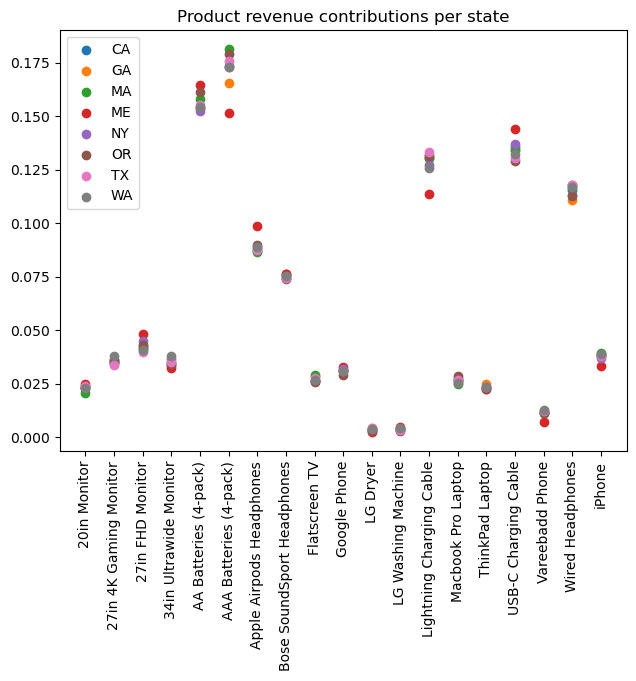

In [51]:
product_order_proportions_per_state = data_2019.groupby(["State", "Product"])["Quantity Ordered"].sum()

states = product_order_proportions_per_state.index.levels[0].to_list()
x = product_order_proportions_per_state.index.levels[1]

fig, ax = plt.subplots()
fig.tight_layout()

for state in range(len(states)):
    ax.scatter(x, product_order_proportions_per_state.loc[[states[state]]] / state_orders.reindex(product_order_proportions_per_state.index.levels[0])[state])

ax.set_title("Product revenue contributions per state")
ax.tick_params(axis="x", labelrotation=90)
ax.legend(states)

Maine is at an extreme in most product revenue contributions. Why do they need so many USB-C cables and Apple Airpods, yet so few AAA batteries and lightning cables? What's going on in Maine?

As a Canadian, I'm not familiar enough with US state demographics, and since this data isn't real, there's no way to tell if there actually is something funky in Maine or if this was done just for fun.

Either way, I think that's a sufficient level of analysis. We got some useful information and questions worth looking into, as well as some recommendations we can make to the store owners to simplify their inventory and optimize revenue.